In [4]:
# To use in Google Colab or Kaggle Notebooks
!pip install datasets==2.14.5
!pip install torch==2.0.0
!pip install transformers==4.34.0
!pip install tqdm==4.66.1
!pip install tokenizers==0.14.1
!pip install pandas==2.0.3
!pip install scikit-learn==1.3.1
!pip install matplotlib==3.8.0
!pip install --upgrade numpy==1.22.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 8.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 13.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2023.9.0
    Uninstalling fsspec-2023.9.0:
      Successfully uninstalled fsspec-2023.9.0
  Attempting uninstall: datasets
    Found existing installation: datasets 2.1.0
    Uninstalling datasets-2.1.0:
      Successfully uninstalled datasets-2.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires pandas<1.6.0dev0,>=1.3, but you have pandas 2.0.2 which is incompatible.
cudf 23.8.0 requires protobuf<5,>

In [5]:
# Importing Libraries
from datasets import load_dataset
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from transformers import DistilBertTokenizer, DistilBertModel
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from enum import Enum
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler

# Use GPU if available
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [6]:
dataset = load_dataset("multi_woz_v22")
train_data = dataset['train']
val_data = dataset['validation']
test_data = dataset['test']

Extracting data files:   0%|          | 0/22 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/8437 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset multi_woz_v22 downloaded and prepared to /root/.cache/huggingface/datasets/multi_woz_v22/v2.2_active_only/2.2.0/7452f16a8b502e97df5c04cc4ee5436464762fa93b1ce778dd14181e79d8b51a. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
def filter_and_preprocess(data):
    """
    Filters a list of dictionaries by only including entries with services
    either "restaurant" or "hotel" and having only one service.

    Parameters:
    - data: list of dictionaries containing a "services" key, which is a list of services.

    Returns:
    - List of filtered dictionaries.
    """
    return [entry for entry in data if set(entry["services"]).issubset({"restaurant", "hotel"}) and len(entry["services"]) == 1]


train_data_filtered = filter_and_preprocess(train_data)
val_data_filtered = filter_and_preprocess(val_data)
test_data_filtered = filter_and_preprocess(test_data)

In [74]:
def toDataFrame(raw_data):
    # Initialize an empty list to store rows as dictionaries
    data = []

    # Loop through each dialogue in the training data
    for dialogue in raw_data:

        # Get the number of turns in this dialogue
        num_turns = len(dialogue['turns']['utterance'])

        # Loop through each turn in the dialogue
        for i in range(num_turns):

            # Extract the utterance and corresponding dialog act for this turn
            utterance = dialogue['turns']['utterance'][i]
            dialogue_act = dialogue['turns']['dialogue_acts'][i]['dialog_act']['act_type']

            # Append as a dictionary to the data list
            data.append({'Utterance': utterance, 'DialogueAct': dialogue_act})

    # Save data as pandas df
    df = pd.DataFrame(data)

    # Separate features and labels
    X = df['Utterance']
    Y = df['DialogueAct']
    
    return X, Y
        
X_train, Y_train = toDataFrame(train_data_filtered)
X_val, Y_val = toDataFrame(val_data_filtered)
X_test, Y_test = toDataFrame(test_data_filtered)

# Final Training
X_test_val = pd.concat([X_test,X_val])
Y_test_val = pd.concat([Y_test, Y_val])

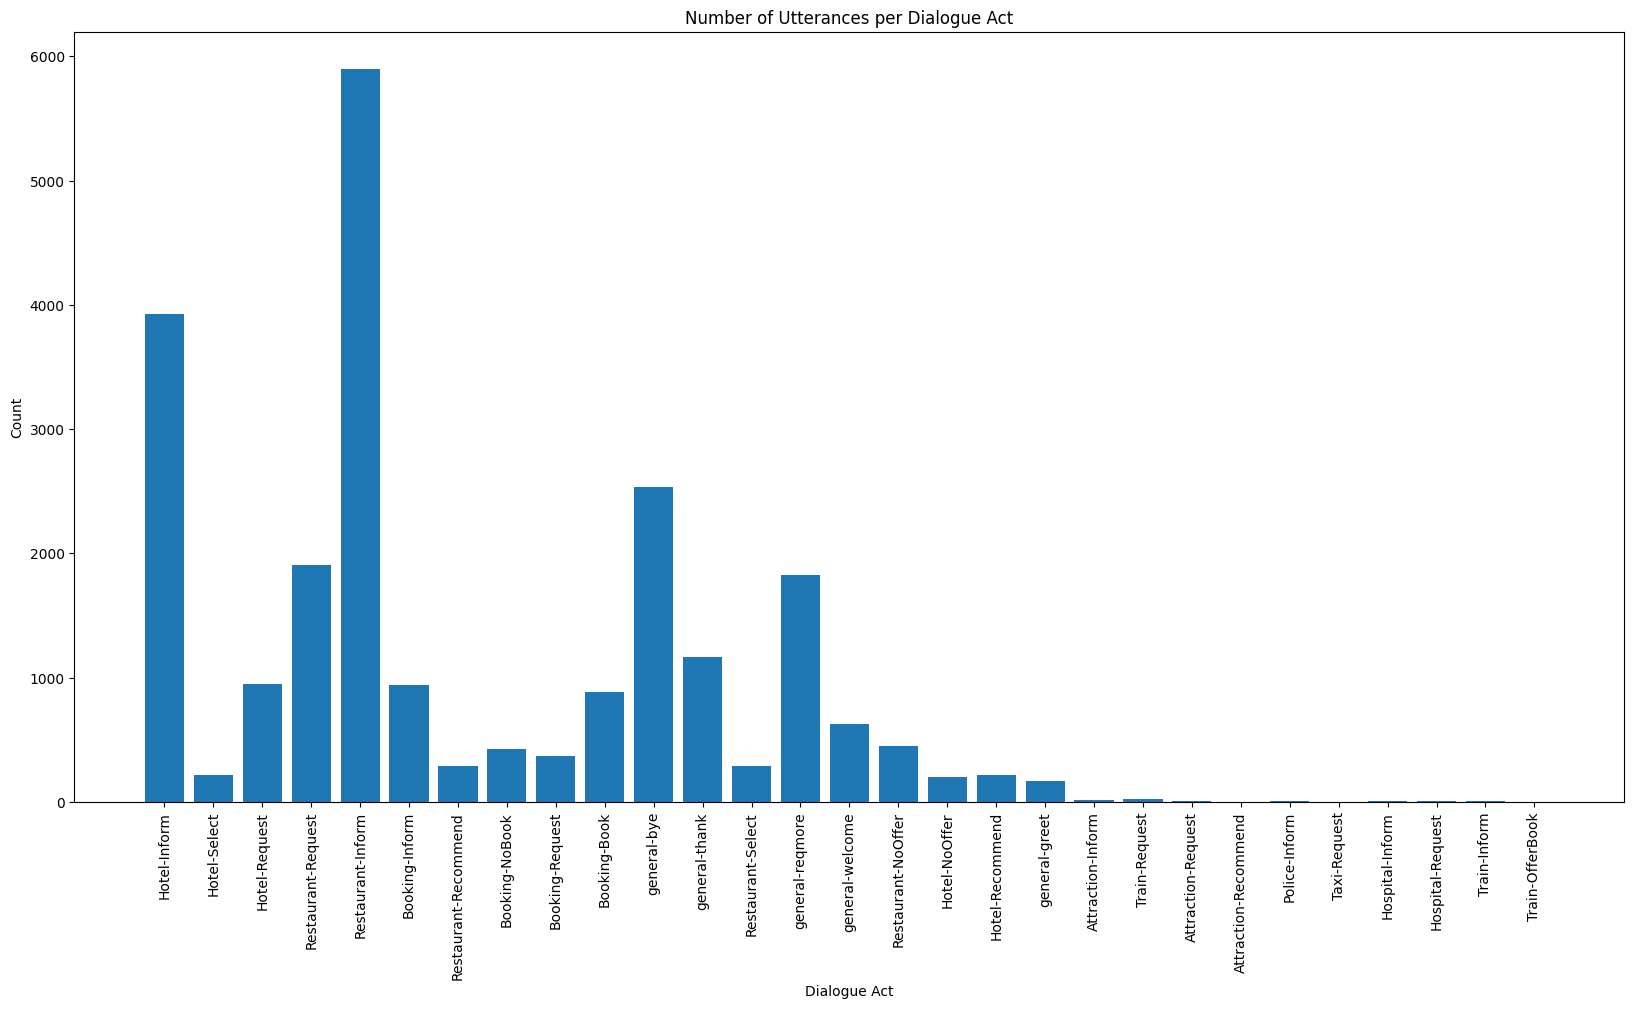

[('Attraction-Recommend', 1), ('Taxi-Request', 1), ('Train-OfferBook', 3), ('Attraction-Request', 5), ('Hospital-Request', 5), ('Police-Inform', 7), ('Hospital-Inform', 7), ('Train-Inform', 10), ('Attraction-Inform', 12), ('Train-Request', 26)]


In [75]:
# Generate a histogram of the number of utterances per dialogue act, knowing that there can be multiple dialogue acts per utterance. 
# To deal with this, we count as a separate utterance each time a dialogue act is present in an utterance, instead of counting more than one
# dialogue act per utterance.

# Initialize an empty dictionary to store the counts of each dialogue act
counts = {}

# Loop through each dialogue act array in the training data

for dialogue_act_array in Y_train:
        # Loop through each dialogue act in the dialogue act array
        for dialogue_act in dialogue_act_array:
            
            # If the dialogue act is already in the dictionary, increment its count by 1
            if dialogue_act in counts:
                counts[dialogue_act] += 1
            
            # If the dialogue act is not already in the dictionary, set its count to 1
            else:
                counts[dialogue_act] = 1

# Plot the histogram
plt.figure(figsize=(20, 10))
plt.bar(counts.keys(), counts.values())
plt.xticks(rotation=90)
plt.xlabel('Dialogue Act')
plt.ylabel('Count')
plt.title('Number of Utterances per Dialogue Act')
plt.show()

# Bottom 10 dialogue acts
sorted_counts = sorted(counts.items(), key=lambda item: item[1])
print(sorted_counts[:10])


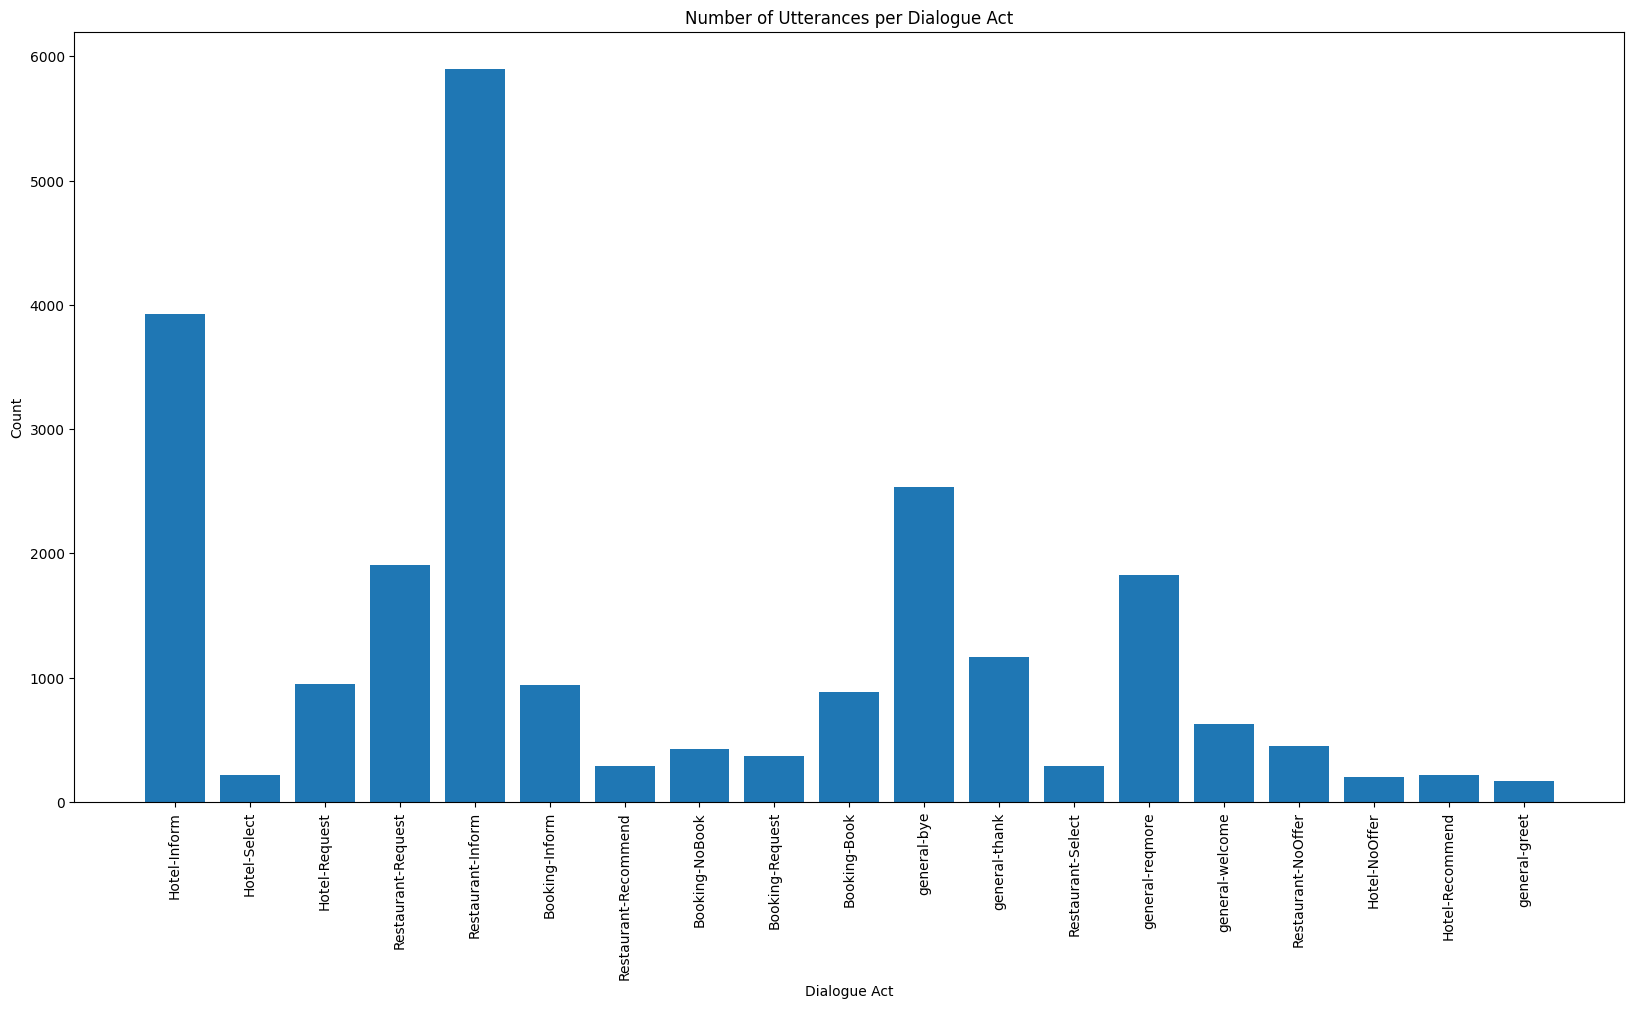

In [76]:
# For every utterance that has multiple dialog acts, remove only the dialog acts that appear in this list (the strings):
#  [('Attraction-Recommend', 1), ('Taxi-Request', 1), ('Train-OfferBook', 3), ('Attraction-Request', 5), ('Hospital-Request', 5), ('Police-Inform', 7), ('Hospital-Inform', 7), ('Train-Inform', 10), ('Attraction-Inform', 12), ('Train-Request', 26)]
# Generalize the previous procedure in a function
def prune_data(Y):
    """
    Prunes the data to exclude the bottom 10 dialogue acts.

    Parameters:
    - Y: list of lists of dialogue acts.

    Returns:
    - Pruned list of lists of dialogue acts.
    """
    # Initialize an empty list to store the pruned data
    Y_pruned = []

    # Loop through each dialogue act array in the data
    for dialogue_act_array in Y:

        # Initialize an empty list to store the pruned dialogue acts for this utterance
        pruned_dialogue_act_array = []

        # Loop through each dialogue act in the dialogue act array
        for dialogue_act in dialogue_act_array:

            # If the dialogue act is not in the list of bottom 10 dialogue acts, append it to the pruned dialogue act array
            if dialogue_act not in ['Attraction-Recommend', 'Taxi-Request', 'Train-OfferBook', 'Attraction-Request', 'Hospital-Request', 'Police-Inform', 'Hospital-Inform', 'Train-Inform', 'Attraction-Inform', 'Train-Request']:
                pruned_dialogue_act_array.append(dialogue_act)

        # Append the pruned dialogue act array to the pruned data
        Y_pruned.append(pruned_dialogue_act_array)
    
    return Y_pruned

def prune_empty_dialogue_acts(X, Y):
    """
    Prunes the data to exclude utterances with no dialogue acts.

    Parameters:
    - X: list of utterances.
    - Y: list of lists of dialogue acts.

    Returns:
    - Pruned lists of utterances and dialogue acts.
    """
    # Initialize empty lists to store the pruned data
    X_pruned = []
    Y_pruned = []

    # Loop through each utterance and corresponding dialogue act array in the data
    for utterance, dialogue_act_array in zip(X, Y):

        # If the dialogue act array is not empty, append the utterance and dialogue act array to the pruned data
        if len(dialogue_act_array) > 0:
            X_pruned.append(utterance)
            Y_pruned.append(dialogue_act_array)
    
    return X_pruned, Y_pruned


# Prune the training, validation, and test data
Y_pruned_train = prune_data(Y_train)
Y_pruned_val = prune_data(Y_val)
Y_pruned_test = prune_data(Y_test)
Y_pruned_test_val = prune_data(Y_test_val)

# Prune empty dialogue acts for training, validation, and test data
X_pruned_train, Y_pruned_train = prune_empty_dialogue_acts(X_train, Y_pruned_train)
X_pruned_val, Y_pruned_val = prune_empty_dialogue_acts(X_val, Y_pruned_val)
X_pruned_test, Y_pruned_test = prune_empty_dialogue_acts(X_test, Y_pruned_test)
X_pruned_test_val, Y_pruned_test_val = prune_empty_dialogue_acts(X_test_val, Y_pruned_test_val)

# Generate a histogram of the number of utterances per dialogue act, knowing that there can be multiple dialogue acts per utterance.
# To deal with this, we count as a separate utterance each time a dialogue act is present in an utterance, instead of counting more than one
# dialogue act per utterance.

# Initialize an empty dictionary to store the counts of each dialogue act
counts = {}

# Loop through each dialogue act array in the training data

for dialogue_act_array in Y_pruned_train:
    # Loop through each dialogue act in the dialogue act array
    for dialogue_act in dialogue_act_array:
        
        # If the dialogue act is already in the dictionary, increment its count by 1
        if dialogue_act in counts:
            counts[dialogue_act] += 1
        
        # If the dialogue act is not already in the dictionary, set its count to 1
        else:
            counts[dialogue_act] = 1

# Plot the histogram
plt.figure(figsize=(20, 10))
plt.bar(counts.keys(), counts.values())
plt.xticks(rotation=90)
plt.xlabel('Dialogue Act')
plt.ylabel('Count')
plt.title('Number of Utterances per Dialogue Act')
plt.show()

In [77]:
from sklearn.preprocessing import MultiLabelBinarizer


# Initialize a MultiLabelBinarizer object
mlb = MultiLabelBinarizer()

# Fit the MultiLabelBinarizer object on the training data
mlb.fit(Y_pruned_train)

# Transform the training, validation, and test data
Y_encoded_train = mlb.transform(Y_pruned_train)
Y_encoded_val = mlb.transform(Y_pruned_val)
Y_encoded_test = mlb.transform(Y_pruned_test)
Y_encoded_test_val = mlb.transform(Y_pruned_test_val)

# Print the shape of the encoded training, validation, and test data
print(Y_encoded_train.shape)
print(Y_encoded_val.shape)
print(Y_encoded_test.shape)
print(Y_encoded_test_val.shape)

# Print the classes
print(mlb.classes_)
# Print the number of classes
print(len(mlb.classes_))

# Print the first 10 encoded training labels
print(Y_encoded_train[:10])

# Print the first 10 decoded training labels
print(mlb.inverse_transform(Y_encoded_train[:10]))

(17749, 19)
(1120, 19)
(1377, 19)
(2497, 19)
['Booking-Book' 'Booking-Inform' 'Booking-NoBook' 'Booking-Request'
 'Hotel-Inform' 'Hotel-NoOffer' 'Hotel-Recommend' 'Hotel-Request'
 'Hotel-Select' 'Restaurant-Inform' 'Restaurant-NoOffer'
 'Restaurant-Recommend' 'Restaurant-Request' 'Restaurant-Select'
 'general-bye' 'general-greet' 'general-reqmore' 'general-thank'
 'general-welcome']
19
[[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[('Hotel-Inform',), ('Hotel-Inform', 'Hotel-Select'), ('Hotel-Inform',), ('Hotel-Request', 'Restaurant-Request'), ('Hotel-Inform', 'Restaurant-Inform'), ('Booking-Inform', 'Hotel-Inform', 'Restaurant-

In [78]:
# Bert Models Enumeration
class BertModelsEnum(str, Enum):
    distilbert_base_uncased = 'distilbert-base-uncased'
    distilbert_base_cased = 'distilbert-base-cased'

bert_model_type = BertModelsEnum.distilbert_base_uncased.value
tokenizer = DistilBertTokenizer.from_pretrained(bert_model_type)
def tokenize_data(X, Y):
    input_encoded = []
    attention_masks = []
    labels = []
    for x,y in zip(X,Y):
        encoded = tokenizer.encode_plus(
            x, 
            add_special_tokens=True, 
            max_length=256, 
            padding='max_length', 
            truncation=True, 
            return_attention_mask=True)
        input_encoded.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        labels.append(y)
    return torch.tensor(input_encoded), torch.tensor(attention_masks), torch.tensor(labels)

train_input, train_masks, train_labels = tokenize_data(X_pruned_train, Y_encoded_train)
val_input, val_masks, val_labels = tokenize_data(X_pruned_val, Y_encoded_val)
test_input, test_masks, test_labels = tokenize_data(X_pruned_test, Y_encoded_test)
test_val_input, test_val_masks, test_val_labels = tokenize_data(X_pruned_test_val, Y_encoded_test_val)

In [79]:
batch_size = 64 # Adjust based on GPU memory requirements
num_workers = 4 # Adjust based on the number of CPU cores

train_data = TensorDataset(train_input, train_masks, train_labels)
val_data = TensorDataset(val_input, val_masks, val_labels)
test_data = TensorDataset(test_input, test_masks, test_labels)
test_val_data = TensorDataset(test_val_input, test_val_masks, test_val_labels)

train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, num_workers=num_workers)
test_loader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)
test_val_loader = DataLoader(test_val_data, batch_size=batch_size, num_workers=num_workers)

In [80]:
class BertClassifier(nn.Module):
    def __init__(self):
        super(BertClassifier, self).__init__()
        self.bert = DistilBertModel.from_pretrained(bert_model_type)
        self.fc = nn.Linear(768, len(mlb.classes_))

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :] # selects the [CLS] token position.
        logits = torch.sigmoid(self.fc(cls_output))
        return logits

In [81]:
class SaveModelWithBestValLoss:
    """
    Class that saves the best model during a training process. If the current epoch's validation loss 
    is smaller than the previous smallest validation loss saved, it saves the model state.
    The best valid loss is initialized to infinity.
    """
    def __init__(
        self, smallest_valid_loss=float('inf')
    ):
        self.smallest_valid_loss = smallest_valid_loss
        
    def save(
        self, current_valid_loss, epoch, model, optimizer, criterion
    ):
        if current_valid_loss < self.smallest_valid_loss:
            self.smallest_valid_loss = current_valid_loss
            print(f"Saving best model for epoch {epoch+1}, with new best validation loss: {self.smallest_valid_loss}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'best_model.pth')

In [47]:
model = BertClassifier()
model = model.to(device)
 
optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.BCELoss()

scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.3, total_iters=40)

save_best_model_instance = SaveModelWithBestValLoss()

# For storing training and validation loss
train_losses = []
val_losses = []

lrs = []
for epoch in range(40):
    model.train()
    
    # Initialize tqdm progress bar
    train_bar = tqdm(train_loader, desc=f'Training Epoch {epoch}')
    
    train_loss = 0.0
    for batch in train_bar:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels.float())
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step()
        
        # Update training loss
        train_loss += loss.item()
        train_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
    
    # Average training loss
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    val_loss = 0.0
    model.eval()

    # Initialize tqdm progress bar for validation
    val_bar = tqdm(val_loader, desc=f'Validation Epoch {epoch}')
    
    with torch.no_grad():
        for batch in val_bar:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            
            # Forward pass
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels.float())
            
            val_loss += loss.item()
            val_bar.set_postfix({'validation_loss': '{:.3f}'.format(loss.item()/len(batch))})
            
    # Average validation loss
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f'Epoch {epoch}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')
    
    # Save model if validation model loss decreases
    save_best_model_instance.save(
        avg_val_loss, epoch, model, optimizer, criterion
    )

Validation Epoch 0: 100%|██████████| 18/18 [00:04<00:00,  3.74it/s, validation_loss=0.077]


Epoch 0, Training Loss: 0.3082803263724279, Validation Loss: 0.21758114877674314
Saving best model for epoch 1, with new best validation loss: 0.21758114877674314



Validation Epoch 1: 100%|██████████| 18/18 [00:04<00:00,  3.73it/s, validation_loss=0.060]


Epoch 1, Training Loss: 0.19027783271434495, Validation Loss: 0.16503202501270506
Saving best model for epoch 2, with new best validation loss: 0.16503202501270506



Validation Epoch 2: 100%|██████████| 18/18 [00:04<00:00,  3.74it/s, validation_loss=0.051]


Epoch 2, Training Loss: 0.15107413874470071, Validation Loss: 0.1398159981601768
Saving best model for epoch 3, with new best validation loss: 0.1398159981601768



Validation Epoch 3: 100%|██████████| 18/18 [00:04<00:00,  3.73it/s, validation_loss=0.043]


Epoch 3, Training Loss: 0.12936369359171648, Validation Loss: 0.12198333731955951
Saving best model for epoch 4, with new best validation loss: 0.12198333731955951



Validation Epoch 4: 100%|██████████| 18/18 [00:04<00:00,  3.73it/s, validation_loss=0.037]


Epoch 4, Training Loss: 0.11393201369926226, Validation Loss: 0.10908069751328892
Saving best model for epoch 5, with new best validation loss: 0.10908069751328892



Validation Epoch 5: 100%|██████████| 18/18 [00:04<00:00,  3.72it/s, validation_loss=0.033]


Epoch 5, Training Loss: 0.10230521755896026, Validation Loss: 0.09915233982933892
Saving best model for epoch 6, with new best validation loss: 0.09915233982933892



Validation Epoch 6: 100%|██████████| 18/18 [00:04<00:00,  3.72it/s, validation_loss=0.030]


Epoch 6, Training Loss: 0.09298045016664395, Validation Loss: 0.09144166194730335
Saving best model for epoch 7, with new best validation loss: 0.09144166194730335



Validation Epoch 7: 100%|██████████| 18/18 [00:04<00:00,  3.73it/s, validation_loss=0.028]


Epoch 7, Training Loss: 0.08530362028119376, Validation Loss: 0.08560558491282994
Saving best model for epoch 8, with new best validation loss: 0.08560558491282994



Validation Epoch 8: 100%|██████████| 18/18 [00:04<00:00,  3.73it/s, validation_loss=0.026]


Epoch 8, Training Loss: 0.07901437466682719, Validation Loss: 0.08061366486880514
Saving best model for epoch 9, with new best validation loss: 0.08061366486880514



Validation Epoch 9: 100%|██████████| 18/18 [00:04<00:00,  3.72it/s, validation_loss=0.025]


Epoch 9, Training Loss: 0.07346811184404994, Validation Loss: 0.07721023571987946
Saving best model for epoch 10, with new best validation loss: 0.07721023571987946



Validation Epoch 10: 100%|██████████| 18/18 [00:04<00:00,  3.74it/s, validation_loss=0.022]


Epoch 10, Training Loss: 0.06873719867238466, Validation Loss: 0.0733644494579898
Saving best model for epoch 11, with new best validation loss: 0.0733644494579898



Validation Epoch 11: 100%|██████████| 18/18 [00:04<00:00,  3.74it/s, validation_loss=0.021]


Epoch 11, Training Loss: 0.0646435822085511, Validation Loss: 0.07016685356696446
Saving best model for epoch 12, with new best validation loss: 0.07016685356696446



Validation Epoch 12: 100%|██████████| 18/18 [00:04<00:00,  3.73it/s, validation_loss=0.019]


Epoch 12, Training Loss: 0.06079262098391279, Validation Loss: 0.06661023013293743
Saving best model for epoch 13, with new best validation loss: 0.06661023013293743



Validation Epoch 13: 100%|██████████| 18/18 [00:04<00:00,  3.72it/s, validation_loss=0.018]


Epoch 13, Training Loss: 0.057431169671656415, Validation Loss: 0.06458273426526123
Saving best model for epoch 14, with new best validation loss: 0.06458273426526123



Validation Epoch 14: 100%|██████████| 18/18 [00:04<00:00,  3.74it/s, validation_loss=0.017]


Epoch 14, Training Loss: 0.05451793401843781, Validation Loss: 0.0626990877919727
Saving best model for epoch 15, with new best validation loss: 0.0626990877919727



Validation Epoch 15: 100%|██████████| 18/18 [00:04<00:00,  3.74it/s, validation_loss=0.016]


Epoch 15, Training Loss: 0.05179979488682404, Validation Loss: 0.06119326170947817
Saving best model for epoch 16, with new best validation loss: 0.06119326170947817



Validation Epoch 16: 100%|██████████| 18/18 [00:04<00:00,  3.71it/s, validation_loss=0.015]


Epoch 16, Training Loss: 0.04921329668689546, Validation Loss: 0.05943261314597395
Saving best model for epoch 17, with new best validation loss: 0.05943261314597395



Validation Epoch 17: 100%|██████████| 18/18 [00:04<00:00,  3.73it/s, validation_loss=0.015]


Epoch 17, Training Loss: 0.04699732810124862, Validation Loss: 0.05770240082508988
Saving best model for epoch 18, with new best validation loss: 0.05770240082508988



Validation Epoch 18: 100%|██████████| 18/18 [00:04<00:00,  3.74it/s, validation_loss=0.014]


Epoch 18, Training Loss: 0.04502456063712887, Validation Loss: 0.056906352233555585
Saving best model for epoch 19, with new best validation loss: 0.056906352233555585



Validation Epoch 19: 100%|██████████| 18/18 [00:04<00:00,  3.74it/s, validation_loss=0.014]


Epoch 19, Training Loss: 0.042866294540250476, Validation Loss: 0.05668366369273928
Saving best model for epoch 20, with new best validation loss: 0.05668366369273928



Validation Epoch 20: 100%|██████████| 18/18 [00:04<00:00,  3.73it/s, validation_loss=0.015]


Epoch 20, Training Loss: 0.041199955010532044, Validation Loss: 0.056043684068653316
Saving best model for epoch 21, with new best validation loss: 0.056043684068653316



Validation Epoch 21: 100%|██████████| 18/18 [00:04<00:00,  3.74it/s, validation_loss=0.013]


Epoch 21, Training Loss: 0.03976419222333449, Validation Loss: 0.05501293018460274
Saving best model for epoch 22, with new best validation loss: 0.05501293018460274



Validation Epoch 22: 100%|██████████| 18/18 [00:04<00:00,  3.74it/s, validation_loss=0.014]


Epoch 22, Training Loss: 0.03817316471002728, Validation Loss: 0.05486661050882605
Saving best model for epoch 23, with new best validation loss: 0.05486661050882605



Validation Epoch 23: 100%|██████████| 18/18 [00:04<00:00,  3.74it/s, validation_loss=0.013]


Epoch 23, Training Loss: 0.03679005649584017, Validation Loss: 0.054022207028335996
Saving best model for epoch 24, with new best validation loss: 0.054022207028335996



Validation Epoch 24: 100%|██████████| 18/18 [00:04<00:00,  3.74it/s, validation_loss=0.014]


Epoch 24, Training Loss: 0.035311106786721475, Validation Loss: 0.05389595921668741
Saving best model for epoch 25, with new best validation loss: 0.05389595921668741



Validation Epoch 25: 100%|██████████| 18/18 [00:04<00:00,  3.74it/s, validation_loss=0.013]


Epoch 25, Training Loss: 0.03394382141476913, Validation Loss: 0.05327625903818342
Saving best model for epoch 26, with new best validation loss: 0.05327625903818342



Validation Epoch 26: 100%|██████████| 18/18 [00:04<00:00,  3.73it/s, validation_loss=0.012]


Epoch 26, Training Loss: 0.032783267872153424, Validation Loss: 0.053199540823698044
Saving best model for epoch 27, with new best validation loss: 0.053199540823698044



Validation Epoch 27: 100%|██████████| 18/18 [00:04<00:00,  3.73it/s, validation_loss=0.013]


Epoch 27, Training Loss: 0.031597777430584534, Validation Loss: 0.05374113139179018


Validation Epoch 28: 100%|██████████| 18/18 [00:04<00:00,  3.75it/s, validation_loss=0.014]


Epoch 28, Training Loss: 0.030515539101425477, Validation Loss: 0.05443435265786118


Validation Epoch 29: 100%|██████████| 18/18 [00:04<00:00,  3.74it/s, validation_loss=0.016]


Epoch 29, Training Loss: 0.029759963984406893, Validation Loss: 0.053960385214951306


Validation Epoch 30: 100%|██████████| 18/18 [00:04<00:00,  3.74it/s, validation_loss=0.015]


Epoch 30, Training Loss: 0.028693055285127472, Validation Loss: 0.053799623209569186


Validation Epoch 31: 100%|██████████| 18/18 [00:04<00:00,  3.74it/s, validation_loss=0.013]


Epoch 31, Training Loss: 0.02784554317606975, Validation Loss: 0.0536416115032302


Validation Epoch 32: 100%|██████████| 18/18 [00:04<00:00,  3.74it/s, validation_loss=0.013]


Epoch 32, Training Loss: 0.026862481528584906, Validation Loss: 0.05368241212434239


Validation Epoch 33: 100%|██████████| 18/18 [00:04<00:00,  3.73it/s, validation_loss=0.014]


Epoch 33, Training Loss: 0.026069554838640013, Validation Loss: 0.054446592926979065


Validation Epoch 34: 100%|██████████| 18/18 [00:04<00:00,  3.74it/s, validation_loss=0.014]


Epoch 34, Training Loss: 0.025345726511541673, Validation Loss: 0.05473640002310276


Validation Epoch 35: 100%|██████████| 18/18 [00:04<00:00,  3.70it/s, validation_loss=0.014]


Epoch 35, Training Loss: 0.024747092896576624, Validation Loss: 0.05375156820648246


Validation Epoch 36: 100%|██████████| 18/18 [00:04<00:00,  3.74it/s, validation_loss=0.014]


Epoch 36, Training Loss: 0.023835722048827213, Validation Loss: 0.05370506478680505


Validation Epoch 37: 100%|██████████| 18/18 [00:04<00:00,  3.72it/s, validation_loss=0.013]


Epoch 37, Training Loss: 0.023308821860030828, Validation Loss: 0.054073657323088914


Validation Epoch 38: 100%|██████████| 18/18 [00:04<00:00,  3.73it/s, validation_loss=0.016]


Epoch 38, Training Loss: 0.022779712430033967, Validation Loss: 0.054660105146467686


Validation Epoch 39: 100%|██████████| 18/18 [00:04<00:00,  3.75it/s, validation_loss=0.011]

Epoch 39, Training Loss: 0.022208526211274827, Validation Loss: 0.054815441370010376


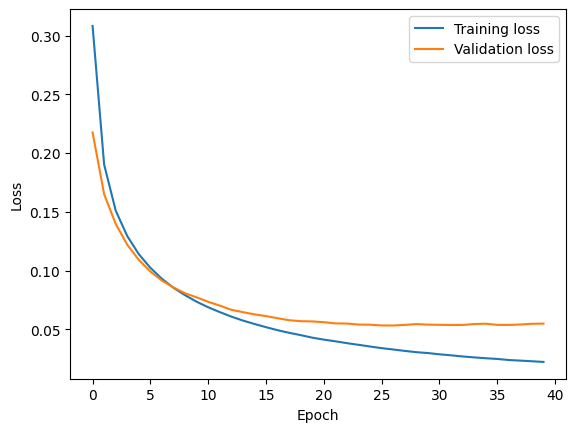

In [48]:
# Plotting validation and training loss
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [49]:
# build the model, without loading the pre-trained weights or fine-tune layers
saved_model = BertClassifier().to(device)
best_model = torch.load('best_model.pth')
saved_model.load_state_dict(best_model['model_state_dict'])

<All keys matched successfully>

In [50]:
all_preds = []
all_labels = []

# Put the Saved Model in evaluation mode
saved_model.eval()

# Disable gradient computation
with torch.no_grad():
    # Initialize tqdm progress bar for Test
    test_bar = tqdm(test_loader, desc='Test')

    for batch in test_bar:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        # Forward pass
        logits = saved_model(input_ids, attention_mask)

        # Get the predicted labels
        #_, preds = torch.max(logits, dim=1)

        # Move preds and labels to CPU for further evaluation (if using GPU)
        preds = logits.cpu().numpy()
        labels = labels.cpu().numpy()

        # Extend the list of predictions and labels
        all_preds.extend(preds)
        all_labels.extend(labels)

Test: 100%|██████████| 22/22 [00:05<00:00,  3.83it/s]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  Calculate metrics for each instance, and find their average (only
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  Calculate metrics for each instance, and find their average (only


                      precision    recall  f1-score   support

        Booking-Book       0.99      0.94      0.96        93
      Booking-Inform       0.96      0.86      0.91        94
      Booking-NoBook       1.00      0.88      0.93        48
     Booking-Request       0.99      0.91      0.95        78
        Hotel-Inform       0.90      0.87      0.89       446
       Hotel-NoOffer       1.00      0.72      0.84        18
     Hotel-Recommend       0.69      0.41      0.51        22
       Hotel-Request       0.80      0.65      0.72       106
        Hotel-Select       0.73      0.47      0.57        17
   Restaurant-Inform       0.89      0.91      0.90       305
  Restaurant-NoOffer       1.00      0.89      0.94        18
Restaurant-Recommend       0.80      0.38      0.52        21
  Restaurant-Request       0.75      0.79      0.77        80
   Restaurant-Select       1.00      0.67      0.80        12
         general-bye       0.89      0.96      0.92       163
       

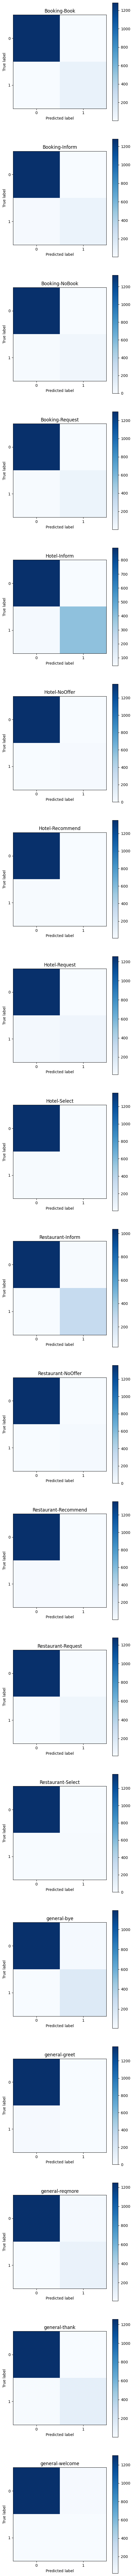

In [57]:
from sklearn.metrics import multilabel_confusion_matrix as mcm, classification_report
import numpy as np
threshold = 0.5
all_preds_binary = []
for all_pred in all_preds:
    local_pred = []
    for old_local_pred in all_pred:
        binary_local_pred = (old_local_pred > threshold).astype(int)
        local_pred.append(binary_local_pred)
    all_preds_binary.append(local_pred)

confusion_matrices = mcm(all_labels, all_preds_binary)
print(classification_report(all_labels, all_preds_binary, target_names=mlb.classes_))

# Plotting
n_labels = confusion_matrices.shape[0]
fig, axes = plt.subplots(n_labels, 1, figsize=(5, 5 * n_labels))

for i, (cm, ax) in enumerate(zip(confusion_matrices, axes)):
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(title=mlb.classes_[i], 
           ylabel='True label',
           xlabel='Predicted label',
           xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=['0', '1'], yticklabels=['0', '1'])

plt.tight_layout()
plt.show()

In [ ]:
# Final Model
model = BertClassifier()
model = model.to(device)
 
optimizer = optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.BCELoss()

scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.3, total_iters=40)

save_best_model_instance = SaveModelWithBestValLoss()

# For storing training and validation loss
train_losses = []
val_losses = []

lrs = []
for epoch in range(32):
    model.train()
    
    # Initialize tqdm progress bar
    train_bar = tqdm(train_loader, desc=f'Training Epoch {epoch}')
    
    train_loss = 0.0
    for batch in train_bar:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels.float())
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        lrs.append(optimizer.param_groups[0]["lr"])
        scheduler.step()
        
        # Update training loss
        train_loss += loss.item()
        train_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
    
    # Average training loss
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation
    val_loss = 0.0
    model.eval()

    # Initialize tqdm progress bar for validation
    val_bar = tqdm(test_val_loader, desc=f'Validation Epoch {epoch}')
    
    with torch.no_grad():
        for batch in val_bar:
            input_ids, attention_mask, labels = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            
            # Forward pass
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels.float())
            
            val_loss += loss.item()
            val_bar.set_postfix({'validation_loss': '{:.3f}'.format(loss.item()/len(batch))})
            
    # Average validation loss
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f'Epoch {epoch}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}')
    
    # Save model if validation model loss decreases
    save_best_model_instance.save(
        avg_val_loss, epoch, model, optimizer, criterion
    )

Training Epoch 0:  31%|███▏      | 87/278 [01:05<02:23,  1.33it/s, training_loss=0.098]

In [ ]:
# Plotting validation and training loss
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# build the model, without loading the pre-trained weights or fine-tune layers
saved_model = BertClassifier().to(device)
best_model = torch.load('best_model.pth')
saved_model.load_state_dict(best_model['model_state_dict'])

all_preds = []
all_labels = []

# Put the Saved Model in evaluation mode
saved_model.eval()

# Disable gradient computation
with torch.no_grad():
    # Initialize tqdm progress bar for Test
    test_bar = tqdm(test_val_loader, desc='Test')

    for batch in test_bar:
        input_ids, attention_mask, labels = batch
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        # Forward pass
        logits = saved_model(input_ids, attention_mask)

        # Get the predicted labels
        #_, preds = torch.max(logits, dim=1)

        # Move preds and labels to CPU for further evaluation (if using GPU)
        preds = logits.cpu().numpy()
        labels = labels.cpu().numpy()

        # Extend the list of predictions and labels
        all_preds.extend(preds)
        all_labels.extend(labels)

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix as mcm, classification_report
import numpy as np
threshold = 0.5
all_preds_binary = []
for all_pred in all_preds:
    local_pred = []
    for old_local_pred in all_pred:
        binary_local_pred = (old_local_pred > threshold).astype(int)
        local_pred.append(binary_local_pred)
    all_preds_binary.append(local_pred)

confusion_matrices = mcm(all_labels, all_preds_binary)
print(classification_report(all_labels, all_preds_binary, target_names=mlb.classes_))

# Plotting
n_labels = confusion_matrices.shape[0]
fig, axes = plt.subplots(n_labels, 1, figsize=(5, 5 * n_labels))

for i, (cm, ax) in enumerate(zip(confusion_matrices, axes)):
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(title=mlb.classes_[i], 
           ylabel='True label',
           xlabel='Predicted label',
           xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=['0', '1'], yticklabels=['0', '1'])

plt.tight_layout()
plt.show()